# Housing price prediction

#### Goal
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, the goal of this project is to predict the final price of each home.

#### Metric 
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.



### Preprocessing

In [80]:
%matplotlib inline

import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from datetime import date 

import matplotlib.pyplot as plt
import numpy as np

In [81]:
pd.set_option('display.max_columns', 500)

In [82]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [83]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Description of variables

In [84]:
# manual defintion of variable types from data_description.txt
nominal_val = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
               'Utilities', 'LotConfig', 'Neighborhood', 'Condition1',
               'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
               'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
               'Electrical', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature',
               'SaleType', 'SaleCondition', 'MoSold', 'YrSold', 'BsmtFinType1',
               'BsmtFinType2',]

ordinal_val = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual',
               'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 
               'KitchenQual', 'Functional', 'FireplaceQu',
               'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']

binary_val = ['CentralAir']

year_val = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']


continuous_val = []
all_columns = train.columns[1:-1]

for col in all_columns:
    other_vals = nominal_val + ordinal_val + binary_val + year_val
    if col not in other_vals:
        continuous_val.append(col)

In [85]:
# storing variable_types into a dict
variable_types = {}
for col in all_columns:
    if col in nominal_val:
        variable_types[col] = 'nominal'
    elif col in ordinal_val:
        variable_types[col] = 'ordinal'
    elif col in year_val:
        variable_types[col] = 'year'
    elif col in binary_val:
        variable_types[col] = 'binary'
    else:
        variable_types[col] = 'continious'

In [86]:
# variable description
for col, var_type in variable_types.items():
    print("{} --> {}".format(col, var_type))

MSSubClass --> nominal
MSZoning --> nominal
LotFrontage --> continious
LotArea --> continious
Street --> nominal
Alley --> nominal
LotShape --> ordinal
LandContour --> nominal
Utilities --> nominal
LotConfig --> nominal
LandSlope --> ordinal
Neighborhood --> nominal
Condition1 --> nominal
Condition2 --> nominal
BldgType --> nominal
HouseStyle --> nominal
OverallQual --> ordinal
OverallCond --> ordinal
YearBuilt --> year
YearRemodAdd --> year
RoofStyle --> nominal
RoofMatl --> nominal
Exterior1st --> nominal
Exterior2nd --> nominal
MasVnrType --> nominal
MasVnrArea --> continious
ExterQual --> ordinal
ExterCond --> ordinal
Foundation --> nominal
BsmtQual --> ordinal
BsmtCond --> ordinal
BsmtExposure --> ordinal
BsmtFinType1 --> nominal
BsmtFinSF1 --> continious
BsmtFinType2 --> nominal
BsmtFinSF2 --> continious
BsmtUnfSF --> continious
TotalBsmtSF --> continious
Heating --> nominal
HeatingQC --> ordinal
CentralAir --> binary
Electrical --> nominal
1stFlrSF --> continious
2ndFlrSF --> co

In [87]:
# Display variables with missing values
train.isna().sum().sort_values(ascending=False)
#test.isna().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
LotConfig           0
OverallCond         0
OverallQual         0
HouseStyle          0
BldgType            0
Condition2          0
BsmtFinSF1          0
MSZoning            0
LotArea             0
Street              0
Condition1          0
Neighborhood        0
LotShape            0
LandContour         0
LandSlope           0
SalePrice 

#### Prepare variables for training

In [88]:
def prepare_variables(df):
    df = drop_useless(df)
    
    for col in year_val:
        df[col] = convert_year(df[col])
    
    df = fill_missing_values(df)
    
    #encode 
    df = encode_all(df)
        
    return df

In [89]:
def drop_useless(df):
    '''drop meaningless columns'''
    return df.drop('Id', axis=1)

def convert_year(year_column):
    '''converting date_years to years from today'''
    return year_column.apply(lambda x: date.today().year - x)

def fill_missing_values(df):
    # replace nan with None in text values
    for col in nominal_val + ordinal_val:
        df[col] = df[col].astype(object).replace(np.nan, 'None')
        
    # replace nan with None in num values
    for col in continuous_val:
        df[col] = df[col].astype(object).replace(np.nan, 0)
    
    #manually interpolate values where 0 would have a meaning 
    df['GarageYrBlt'] = df['GarageYrBlt'].interpolate(method = 'linear')
    df['LotFrontage'] = df['LotFrontage'].interpolate(method = 'linear')
    df['MasVnrArea'] = df['MasVnrArea'].interpolate(method = 'linear')
    return df

def encode_all(df):
    #nominal values -> one-hot-encoding
    df = pd.get_dummies(data=df, columns=nominal_val)

    #ordinal -> encoded based on order
    qual_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None" : 0}
    for col in ordinal_val:
        if 'Gd' in df[col].unique():
            df[col] = df[col].replace(qual_map)
    
    df['LotShape']=df['LotShape'].replace({"Reg": 1, "IR1": 2, "IR2": 3, "IR3": 4})
    df['LandSlope']=df['LandSlope'].replace({"Gtl": 1, "Mod": 2, "Sev": 3})
    df['Functional']=df['Functional'].replace({'Typ': 1, 'Min1': 2, 'Maj1': 3, 'Min2': 4,
                              'Mod': 5, 'Maj2': 6, 'Sev': 7, "None": 1}) 
                                #in test two values are missing for functional, they are set to typical
    df['GarageFinish']=df['GarageFinish'].replace({"Fin": 3, "RFn": 2, "Unf": 1, "None": 0})
    df['BsmtExposure']=df['BsmtExposure'].replace({"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "None": 0})

    #binary
    df['CentralAir']=df['CentralAir'].replace({"Y": 1, "N": 0})
    return df

# NOTE: ordinal and categorical values might be taken as continious

In [90]:
train = prepare_variables(train)
test = prepare_variables(test)

print('Missing values:')
print(train.isnull().values.any())
print(test.isnull().values.any())



Missing values:
False
False


/Users/michellekoks/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


#### Explore variables and drop outliers

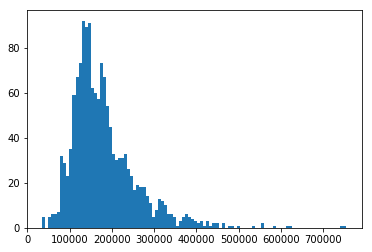

In [30]:
plt.hist(train['SalePrice'], bins=100)
plt.show()

In [31]:
continious_numbers = []
for col in continuous_val:
    if len(train[col].unique()) > 25:
        continious_numbers.append(col)

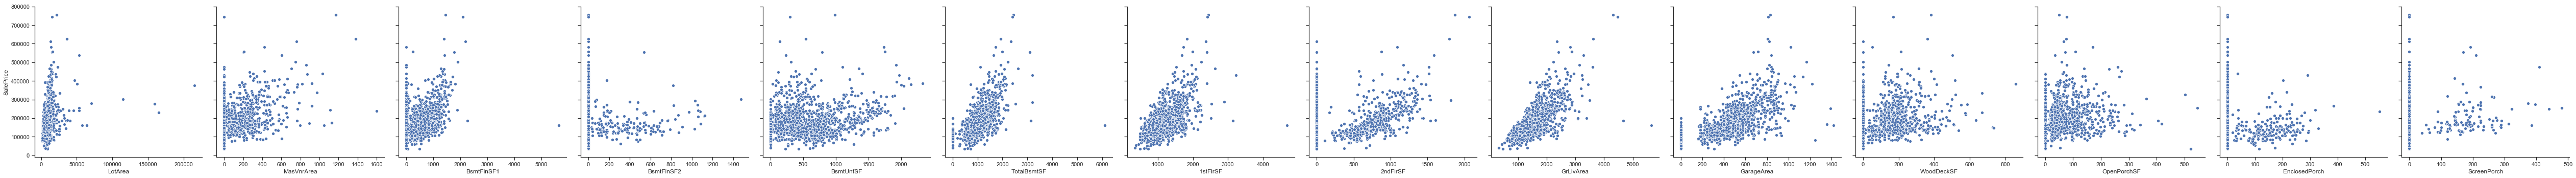

In [32]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.pairplot(train, x_vars=continious_numbers[1:], y_vars='SalePrice', height=5)


In [33]:
print(len(train))
train = train[train['SalePrice'] < 700000]
train = train[train['LotFrontage'] < 300]
train = train[train['LotArea'] < 100000]
train = train[train['TotalBsmtSF'] < 3000]
train = train[train['BsmtFinSF2'] < 1400]
print(len(train))

1460
1447


### Linear Regression

In [34]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [35]:
lm = LinearRegression().fit(X, y)

In [36]:
lm.score(X, y)

0.9298611624009935

In [37]:
y_pred = lm.predict(X_test)

In [38]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(1447, 24)

In [39]:
lm_new = LinearRegression().fit(X_new, y)
lm_new.score(X_new, y)

0.8562981027536569

In [40]:
features = list(model.get_support())
cols = list(train.columns)[:-1]
selected_features_svm = pd.DataFrame({'feat':features, 'cols': cols})

selected_features_svm[selected_features_svm['feat'] == True]

,feat,cols
0,True,LotFrontage
1,True,LotArea
4,True,OverallQual
5,True,OverallCond
6,True,YearBuilt
7,True,YearRemodAdd
8,True,MasVnrArea
14,True,BsmtFinSF1
15,True,BsmtFinSF2
16,True,BsmtUnfSF


### Gradient boosting with XGBoost

In [93]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [94]:
train.head(2)

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,BsmtFinTyp

In [95]:
y_train.head(2)

1292    107500
1018    160000
Name: SalePrice, dtype: int64

In [96]:
d_train = xgb.DMatrix(X_train.as_matrix(),label=y_train.as_matrix())
d_test = xgb.DMatrix(X_test.as_matrix(),label=y_test.as_matrix())

/Users/michellekoks/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/michellekoks/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [97]:
#Build the model
params = {
    "eta": 0.1,
    #"max_depth": 6,
    "objective": "reg:linear",
    #"booster": "gbtree",
    "silent": 1,
    #"base_score": np.mean(y_train),
    #'n_estimators': 1000,
    #"eval_metric": "logloss"
}

evals_result = {}
bst = xgb.train(params, d_train, 3000, [(d_test, "test"), (d_train, "train")], verbose_eval=200)

[0]	test-rmse:180365	train-rmse:178421
[200]	test-rmse:28161.9	train-rmse:2620.65
[400]	test-rmse:28160	train-rmse:791.638
[600]	test-rmse:28148.2	train-rmse:246.587
[800]	test-rmse:28149.6	train-rmse:79.8501
[1000]	test-rmse:28149.3	train-rmse:22.7517
[1200]	test-rmse:28149.6	train-rmse:7.1718
[1400]	test-rmse:28149.5	train-rmse:2.49437
[1600]	test-rmse:28149.6	train-rmse:0.798148
[1800]	test-rmse:28149.5	train-rmse:0.304942
[2000]	test-rmse:28149.5	train-rmse:0.304297
[2200]	test-rmse:28149.5	train-rmse:0.304297
[2400]	test-rmse:28149.5	train-rmse:0.304297
[2600]	test-rmse:28149.5	train-rmse:0.304297
[2800]	test-rmse:28149.5	train-rmse:0.304297
[2999]	test-rmse:28149.5	train-rmse:0.304297


##### Assumption for the cause of the following error:  one-hot-encoding transports unique values to columns. In train, for some variables, there are less unique values, which results in less columns and less features:

In [98]:
final_test = xgb.DMatrix(test.as_matrix())
y_pred = bst.predict(final_test)

/Users/michellekoks/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261']
expected f266, f270, f268, f272, f271, f269, f263, f267, f265, f264, f262 in input data

In [ ]:
# Create empty submission dataframe
sub = pd.DataFrame()

# Insert ID and Predictions into dataframe
sub['Id'] = test_ids #df_test['Id']
sub['SalePrice'] = y_pred
print(sub.to_csv)
# Output submission file
sub.to_csv('submission.csv',index=False)

### Feature importance (Under Construction)

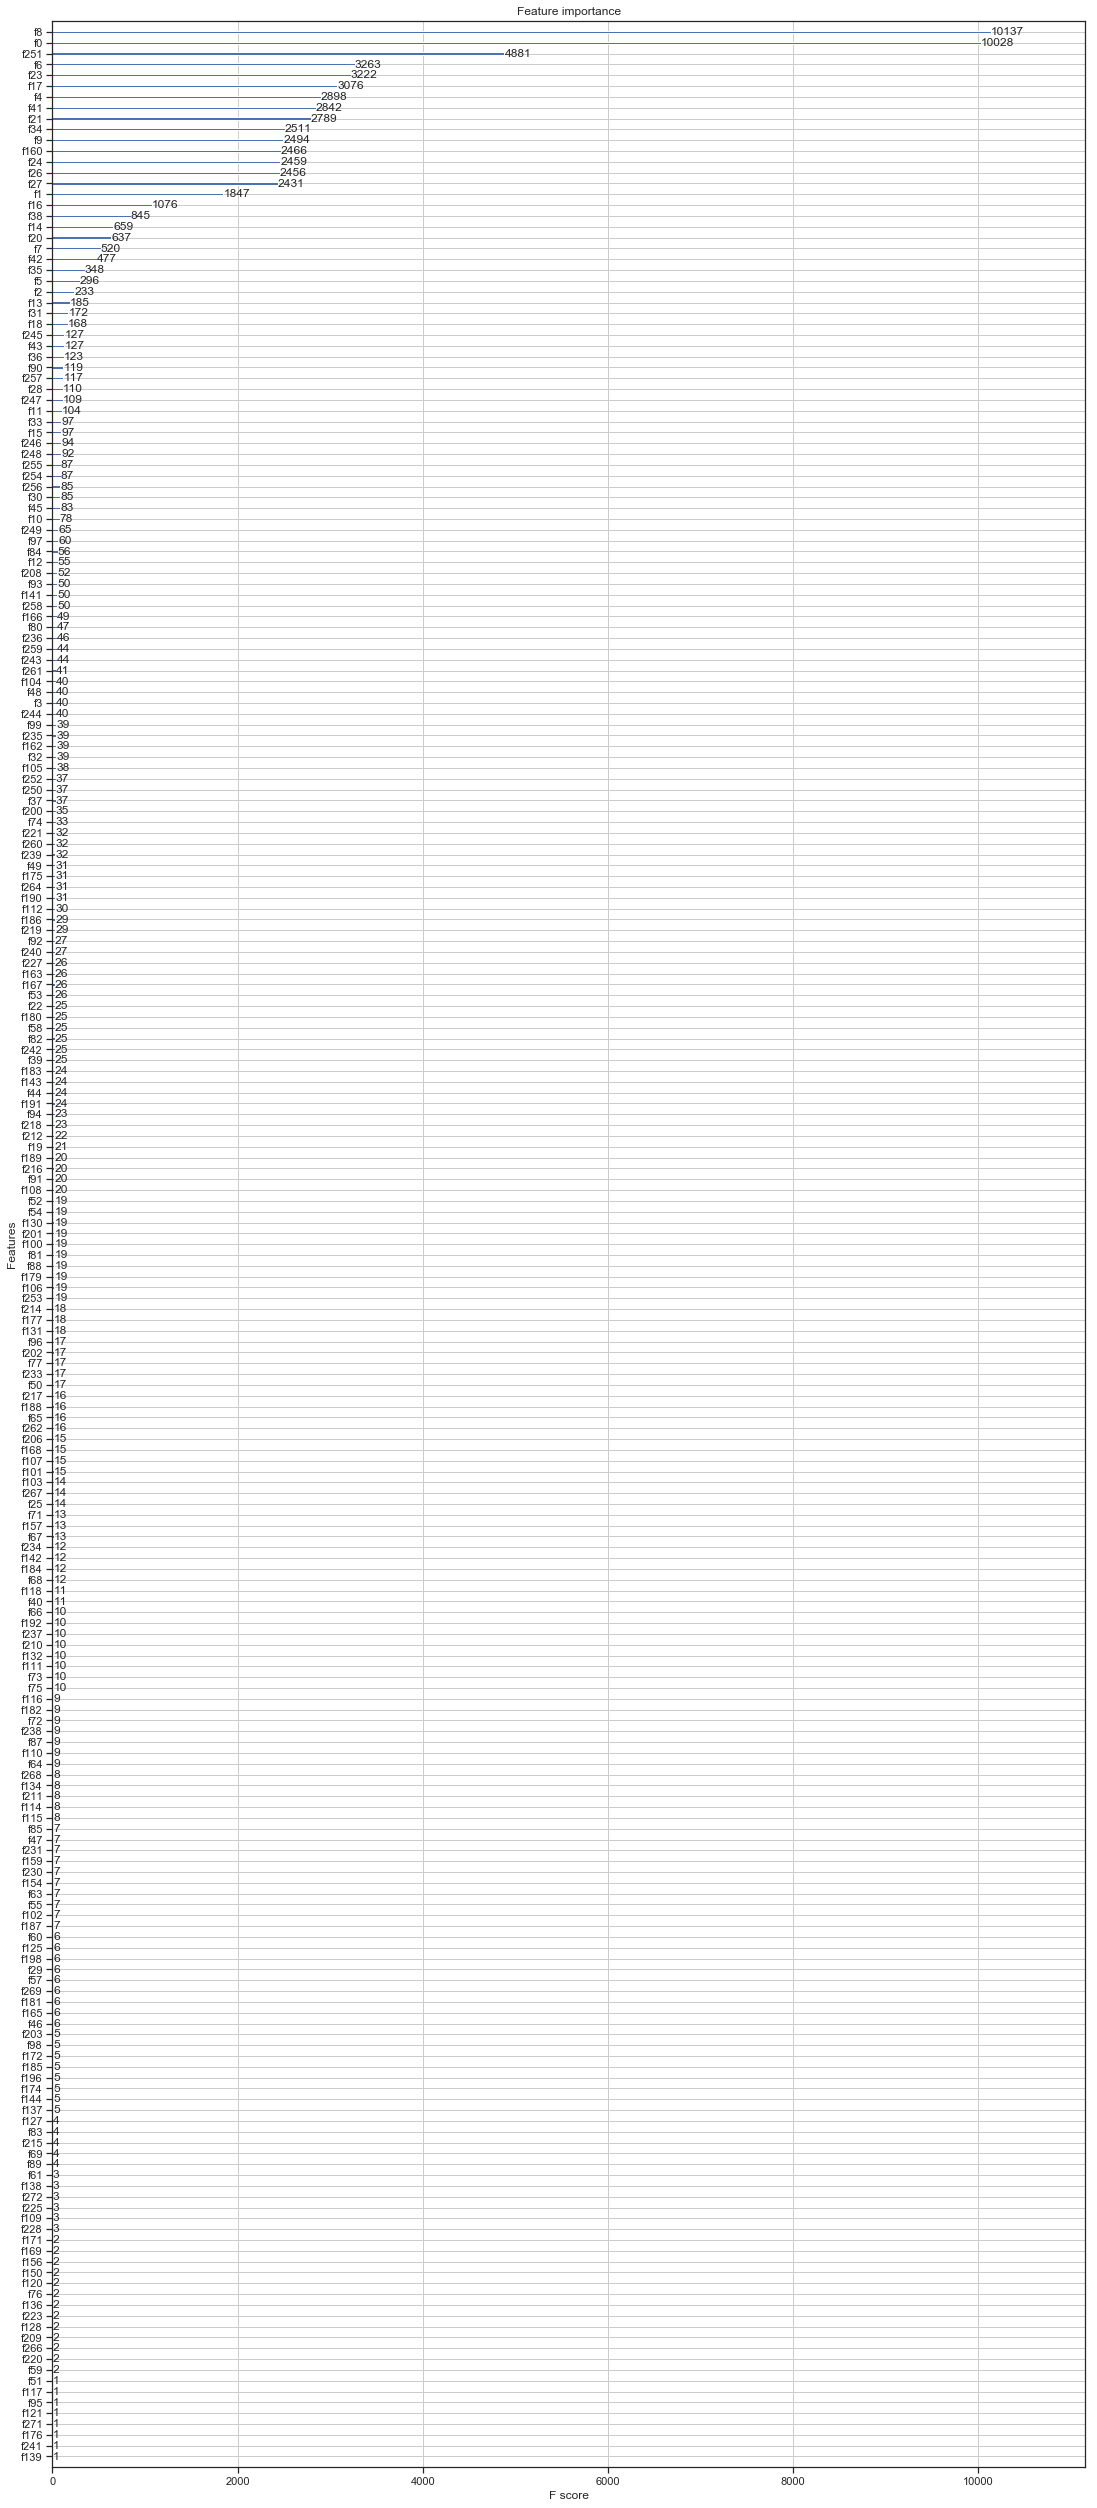

In [39]:
xgb.plot_importance(bst)
fig = plt.gcf()
fig.set_size_inches(18.5, 45)

In [40]:
bst.feature_names

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'f12',
 'f13',
 'f14',
 'f15',
 'f16',
 'f17',
 'f18',
 'f19',
 'f20',
 'f21',
 'f22',
 'f23',
 'f24',
 'f25',
 'f26',
 'f27',
 'f28',
 'f29',
 'f30',
 'f31',
 'f32',
 'f33',
 'f34',
 'f35',
 'f36',
 'f37',
 'f38',
 'f39',
 'f40',
 'f41',
 'f42',
 'f43',
 'f44',
 'f45',
 'f46',
 'f47',
 'f48',
 'f49',
 'f50',
 'f51',
 'f52',
 'f53',
 'f54',
 'f55',
 'f56',
 'f57',
 'f58',
 'f59',
 'f60',
 'f61',
 'f62',
 'f63',
 'f64',
 'f65',
 'f66',
 'f67',
 'f68',
 'f69',
 'f70',
 'f71',
 'f72',
 'f73',
 'f74',
 'f75',
 'f76',
 'f77',
 'f78',
 'f79',
 'f80',
 'f81',
 'f82',
 'f83',
 'f84',
 'f85',
 'f86',
 'f87',
 'f88',
 'f89',
 'f90',
 'f91',
 'f92',
 'f93',
 'f94',
 'f95',
 'f96',
 'f97',
 'f98',
 'f99',
 'f100',
 'f101',
 'f102',
 'f103',
 'f104',
 'f105',
 'f106',
 'f107',
 'f108',
 'f109',
 'f110',
 'f111',
 'f112',
 'f113',
 'f114',
 'f115',
 'f116',
 'f117',
 'f118',
 'f119',
 'f120',
 'f121',
 'f122',
 'f

In [41]:
feature_weights = bst.get_score(importance_type='weight')
features_nr = []
f_score = []


for key, value in feature_weights.items():
    features_nr.append(int(key[1:]))
    f_score.append(value)
    

In [42]:
feature_weights.values()

dict_values([2898, 3222, 3263, 3076, 10028, 85, 296, 46, 9, 659, 37, 22, 21, 637, 23, 39, 110, 1847, 2511, 520, 1076, 12, 12, 2494, 78, 2842, 845, 97, 2, 7, 25, 23, 127, 32, 168, 17, 104, 477, 55, 2459, 172, 20, 39, 5, 2789, 92, 17, 123, 44, 10137, 37, 185, 117, 39, 2456, 20, 9, 97, 29, 41, 40, 30, 348, 31, 37, 13, 83, 233, 16, 47, 29, 19, 6, 24, 94, 27, 19, 85, 65, 50, 60, 2466, 2431, 44, 1, 39, 13, 119, 20, 40, 6, 52, 26, 19, 127, 87, 10, 15, 27, 87, 4, 16, 49, 26, 16, 56, 19, 25, 31, 15, 8, 8, 38, 19, 24, 31, 8, 14, 19, 7, 6, 4881, 32, 7, 20, 25, 10, 10, 6, 109, 7, 10, 5, 26, 40, 19, 50, 18, 14, 40, 25, 17, 6, 31, 7, 4, 3, 9, 17, 32, 16, 9, 10, 18, 7, 3, 14, 50, 15, 1, 5, 7, 10, 19, 2, 13, 33, 18, 24, 10, 25, 6, 7, 7, 26, 4, 1, 2, 25, 9, 2, 12, 15, 6, 17, 5, 24, 8, 5, 3, 7, 9, 3, 10, 19, 11, 3, 35, 2, 19, 12, 5, 2, 1, 5, 3, 6, 1, 4, 1, 2, 9, 5, 4, 1, 8, 2, 1, 11, 2, 2, 2, 2, 6, 2])

In [43]:
f_scores = pd.DataFrame({'num': features_nr, 'f-score': f_score}).sort_values('f-score', ascending = False)
f_scores

,num,f-score
49,8,10137
4,0,10028
121,251,4881
2,6,3263
1,23,3222
3,17,3076
0,4,2898
25,41,2842
44,21,2789
18,34,2511


In [44]:
f_scores['feature_name'] = f_scores['num'].apply(lambda x: X_train.columns[int(x)])

In [45]:
f_scores.sort_values('f-score', ascending=False)

,num,f-score,feature_name
49,8,10137,MasVnrArea
4,0,10028,LotFrontage
121,251,4881,MoSold_10
2,6,3263,YearBuilt
1,23,3222,GrLivArea
3,17,3076,TotalBsmtSF
0,4,2898,OverallQual
25,41,2842,WoodDeckSF
44,21,2789,2ndFlrSF
18,34,2511,FireplaceQu


ImportError: You must install graphviz to plot tree

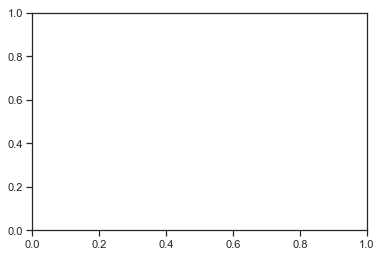

In [177]:
xgb.plot_tree(bst, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(25, 50)

In [161]:
from xgboost.sklearn import XGBRegressor

# Initialize model
model = XGBRegressor()                  

# Fit the model on our data
model.fit(x_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [162]:
# Metrics for root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = model.predict(x_train)

# Print RMSE
print(sqrt(mean_squared_error(y_train, y_pred)))
# Print RMSE(log(y_train),log(y_pred))
#print(sqrt(mean_squared_error(np.log(y_train), np.log(y_pred))))


# Predict test set
y_pred = model.predict(x_test)


660.3733484528852


ValueError: could not convert string to float: 'None'